In [1]:
import json

In [2]:
info_download = json.load(open("info_download.json"))

In [3]:
info_download['results']['drug']

{'event': {'export_date': '2023-02-11',
  'partitions': [{'display_name': '2004 Q1 (part 1 of 5)',
    'file': 'https://download.open.fda.gov/drug/event/2004q1/drug-event-0001-of-0005.json.zip',
    'size_mb': '44.95',
    'records': 12000},
   {'display_name': '2004 Q1 (part 2 of 5)',
    'file': 'https://download.open.fda.gov/drug/event/2004q1/drug-event-0002-of-0005.json.zip',
    'size_mb': '5.92',
    'records': 12000},
   {'display_name': '2004 Q1 (part 3 of 5)',
    'file': 'https://download.open.fda.gov/drug/event/2004q1/drug-event-0003-of-0005.json.zip',
    'size_mb': '40.83',
    'records': 12000},
   {'display_name': '2004 Q1 (part 4 of 5)',
    'file': 'https://download.open.fda.gov/drug/event/2004q1/drug-event-0004-of-0005.json.zip',
    'size_mb': '104.84',
    'records': 12000},
   {'display_name': '2004 Q1 (part 5 of 5)',
    'file': 'https://download.open.fda.gov/drug/event/2004q1/drug-event-0005-of-0005.json.zip',
    'size_mb': '42.79',
    'records': 3947},
   {'di

In [17]:
import zipfile, urllib
from io import BytesIO
url = "https://download.open.fda.gov/drug/event/2004q1/drug-event-0001-of-0005.json.zip"
resp = urllib.request.urlopen(url)
myzip = zipfile.ZipFile(BytesIO(resp.read()))
with myzip.open(myzip.namelist()[0]) as f:  
    data = f.read()  
    data_json2 = json.loads(data.decode('utf-8'))


In [18]:
data_json2['results'][0].keys()

dict_keys(['safetyreportid', 'transmissiondateformat', 'transmissiondate', 'serious', 'seriousnessdeath', 'receivedateformat', 'receivedate', 'receiptdateformat', 'receiptdate', 'fulfillexpeditecriteria', 'companynumb', 'primarysource', 'sender', 'receiver', 'patient'])

In [3]:
import pandas as pd
def date_difference(date_yyyymmdd, date_yyyymm):
        month_diff = (int(date_yyyymmdd[:4])-int(date_yyyymm[:4]))*12 
        if len(date_yyyymm) == 4:
            return month_diff
        return month_diff + (int(date_yyyymm[4:]) - int(date_yyyymmdd[4:6]))
    
def preprocess_data(json_file: dict):
    rows = []
    drug_infos = []
    for result in json_file['results']:
        rows.append({'SourceCountry': result['primarysourcecountry'] if 'primarysourcecountry' in result.keys() else None,
                     'Qualification': result['primarysource']['qualification'] if 'qualification' in result['primarysource'].keys() else None,
                     'SetAge': result['patient']['patientonsetage'] if 'patientonsetage' in result['patient'].keys() else None,
                     'Sex': result['patient']['patientsex'] if 'patientsex' in result['patient'].keys() else None,
                     'Serious': result['serious']
                    })
        for drug in result['patient']['drug']:
            if 'activesubstance' not in drug.keys():
                continue
            rows[-1][drug['activesubstance']['activesubstancename']] = 1
            if 'DrugChar' + str(drug['drugcharacterization']) in rows[-1].keys():
                rows[-1]['DrugChar' + str(drug['drugcharacterization'])] += 1
            else:
                rows[-1]['DrugChar' + str(drug['drugcharacterization'])] = 1
            if 'drugstructuredosagenumb' in drug.keys():
                rows[-1][drug['activesubstance']['activesubstancename']+'Dosage'] = drug['drugstructuredosagenumb']
            else:
                rows[-1][drug['activesubstance']['activesubstancename']+'Dosage'] = 'Missing'
            if 'drugstartdate' in drug.keys():
                if 'MostRecentDrug' in rows[-1].keys():
                    rows[-1]['MostRecentDrug'] = min(rows[-1]['MostRecentDrug'], date_difference(result['receivedate'], drug['drugstartdate']))
                else:
                    rows[-1]['MostRecentDrug'] = date_difference(result['receivedate'], drug['drugstartdate'])
    return rows
        


In [4]:
import zipfile, urllib
from io import BytesIO
rows = []
max_file = 2
filtering_string = "2019 Q4"

def get_multiple_files(info_download, max_file, filtering_string):
    for info in info_download['results']['drug']['event']['partitions']:
        if filtering_string in info['display_name'] and max_file != 0:
            max_file -= 1
            url = info['file']
            resp = urllib.request.urlopen(url)
            myzip = zipfile.ZipFile(BytesIO(resp.read()))
            with myzip.open(myzip.namelist()[0]) as f:  
                data = f.read()  
                data_json = json.loads(data.decode('utf-8'))
            rows.extend(preprocess_data(data_json))
    return rows
rows = get_multiple_files(info_download, max_file, filtering_string)

In [5]:
import pandas as pd 
df = pd.DataFrame(rows)

In [6]:
a = pd.DataFrame(df.sum()).reset_index()
a = a.drop(0,axis=0)


C:\Users\mpilc\AppData\Local\Temp\ipykernel_4716\2570180808.py:1: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  a = pd.DataFrame(df.sum()).reset_index()


In [8]:
PERSON_COLUMNS = ['SourceCountry', 'Qualification', 'SetAge', 'Sex', 'Serious']
df_preprocessed = df.drop([name for name in list(a[a[0] <= 3]['index']) if name not in PERSON_COLUMNS], axis=1) 

In [9]:
df_preprocessed.head()

,SourceCountry,Qualification,SetAge,Sex,Serious,CAPECITABINE,DrugChar1,CAPECITABINEDosage,MostRecentDrug,GABAPENTIN,...,ETHACRYNIC ACIDDosage,SOMATOSTATINDosage,BUTORPHANOL TARTRATEDosage,INDIGOTINDISULFONATE SODIUMDosage,ALCAFTADINEDosage,CISATRACURIUMDosage,DESFLURANEDosage,CHLORPROPAMIDEDosage,NAFRONYL OXALATEDosage,DEXAMETHASONE SODIUM SUCCINATEDosage
0,US,3,41,1,1,1.0,1.0,Missing,503.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,US,3,None,2,2,NaN,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,US,None,53,1,2,NaN,1.0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,US,3,None,2,2,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,US,5,72,1,1,NaN,2.0,NaN,1346.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df.describe()

,CAPECITABINE,DrugChar1,MostRecentDrug,GABAPENTIN,DrugChar2,OMEPRAZOLE,LORAZEPAM,ATROPINE SULFATE\DIPHENOXYLATE,CHOLECALCIFEROL,PIRFENIDONE,...,BACITRACIN\NEOMYCIN SULFATE\POLYMYXIN B SULFATE,PROPATYL NITRATE,AMINOBENZOIC ACID,CLONIXIN\CYCLOBENZAPRINE,CALCIUM PHOSPHATE,ASCORBIC ACID\BIOTIN\CALCIUM PANTOTHENATE\CYANOCOBALAMIN\FOLIC ACID\NIACINAMIDE\PYRIDOXINE HYDROCHLORIDE\RIBOFLAVIN\THIAMINE HYDROCHLORIDE,BIOTIN\VITAMIN B COMPLEX,SARGRAMOSTIM,FISH OIL\MEDIUM-CHAIN TRIGLYCERIDES\OLIVE OIL\SOYBEAN OIL,DIMETHYL SULFOXIDE
count,378.0,59997.000000,33268.000000,1194.0,17419.000000,1242.0,554.0,2.0,837.0,264.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,1.0,2.010501,440.495972,1.0,5.156955,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
std,0.0,2.563798,415.482256,0.0,6.356351,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.0,1.000000,-86.000000,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
25%,1.0,1.000000,14.000000,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
50%,1.0,1.000000,336.000000,1.0,3.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75%,1.0,2.000000,817.000000,1.0,7.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
max,1.0,115.000000,1428.000000,1.0,135.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [113]:
df['Serious'].value_counts()

1    8202
2    3798
Name: Serious, dtype: int64

In [87]:
drug_names = set([drug_info[0] for drugs_info in drug_infos for drug_info in drugs_info])


2610


In [21]:
for i in tqdm(range(0, len([column for column in df_preprocessed.columns if column not in PERSON_COLUMNS]), 10)):
    df_preprocessed[[column for column in df_preprocessed.columns if column not in PERSON_COLUMNS][i:i+10]] = df_preprocessed[[column for column in df_preprocessed.columns if column not in PERSON_COLUMNS][i:i+10]].replace(np.nan, 0)

100%|████████████████████████████████████████████████████████████████████████████████| 462/462 [34:43<00:00,  4.51s/it]


In [34]:
df_preprocessed.drop(columns=df_preprocessed.columns[(df_preprocessed == 'Missing').any()], axis=1, inplace=True)

In [36]:

y = df_preprocessed['Serious']
X = df_preprocessed.drop('Serious', axis = 1)

In [61]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2)


In [62]:

from sklearn.impute import SimpleImputer 
ss_cont = SimpleImputer(strategy = 'mean') 
ss_cat = SimpleImputer(missing_values = None, strategy = 'most_frequent')


In [63]:
X_train[['Sex', 'Qualification']] = ss_cat.fit_transform(X_train[['Sex', 'Qualification']])
X_test[['Sex', 'Qualification']] = ss_cat.transform(X_test[['Sex', 'Qualification']])


In [64]:
X_train[['SetAge', 'MostRecentDrug']] = ss_cont.fit_transform(X_train[['SetAge', 'MostRecentDrug']])
X_test[['SetAge', 'MostRecentDrug']] = ss_cont.transform(X_test[['SetAge', 'MostRecentDrug']])


In [65]:
X_train.isna().sum()

SourceCountry                           524
Qualification                             0
SetAge                                    0
Sex                                       0
CAPECITABINE                              0
                                       ... 
RANIMUSTINEDosage                         0
PILSICAINIDE HYDROCHLORIDEDosage          0
CEFPROZILDosage                           0
CHLORPROPAMIDEDosage                      0
DEXAMETHASONE SODIUM SUCCINATEDosage      0
Length: 1960, dtype: int64

In [66]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)


In [67]:
X_train = X_train.drop('SourceCountry', axis = 1)
X_test = X_test.drop('SourceCountry', axis = 1)


In [69]:

from imblearn.over_sampling import RandomOverSampler
OvSamp = RandomOverSampler()

X_train,y_train = OvSamp.fit_resample(X_train,y_train)

In [70]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

C:\Users\mpilc\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.63

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

In [71]:
from sklearn.ensemble import ExtraTreesClassifier
et = ExtraTreesClassifier()
et.fit(X_train, y_train)
et.score(X_test, y_test)

0.765625

In [74]:
et.score(X_train, y_train)

0.9798767802848456

Text(0.5, 1.0, 'Feature importance with the ExtraTrees model')

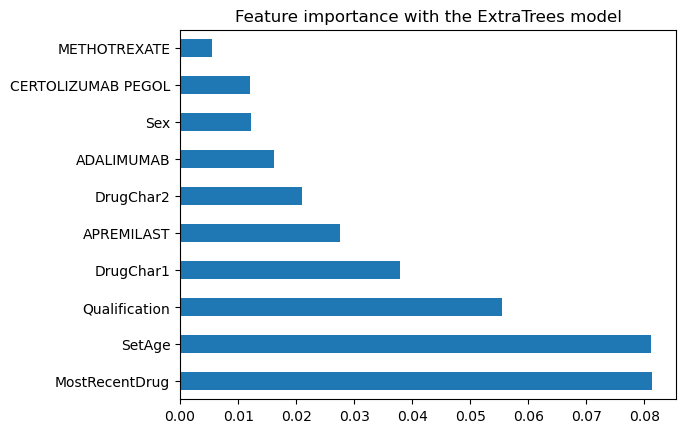

In [73]:
feat_importances = pd.Series(et.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
import matplotlib.pyplot as plt
plt.title('Feature importance with the ExtraTrees model')

In [64]:
set(result['serious'] for result in data_json['results'])

{'1', '2'}

In [56]:
len(set([brand for result in data_json['results'] for drug in result['patient']['drug'] if 'openfda' in drug.keys() and 'substance_name' in drug['openfda'].keys() for brand in drug['openfda']['substance_name']]))

1762

In [82]:
max([len(drug) for result in data_json['results']  for drug in result['patient']['drug'] ])

24

In [60]:
len(set([drug['activesubstance']['activesubstancename'] if "activesubstance" in drug.keys() else None for result in data_json['results']  for drug in result['patient']['drug'] ]))

2610

In [84]:
print(max([len(drug_info) for drug_info in drug_infos]))

135
